In [1]:
import torch
import torch.nn as nn

In [2]:
import Encoder as E
import Decoder as D
from torch.nn import functional as F

x = torch.randn(16,3,28,28,device = 'cuda')
model1 = E.ENCODER1(in_feat_dim=3,codebook_dim=128,hidden_dim=128).to(device = 'cuda')
model2 = D.DECODER1(in_feat_dim=128,out_feat_dim=3,hidden_dim=128).to(device = 'cuda')

z_e = torch.randn(128,128,6,6)
z_e_lower = torch.randn(128,128,12,12)
z_e_lower_tilde = torch.randn(128,128,12,12)

print(z_e.shape)
print(z_e_lower.shape)
print(z_e_lower_tilde.shape)
print((1-F.cosine_similarity(z_e_lower, z_e_lower_tilde, dim = 1)).shape)
print((torch.zeros(z_e_lower.shape[0], z_e_lower.shape[2], z_e_lower.shape[2])).shape)
print(torch.max(1-F.cosine_similarity(z_e_lower, z_e_lower_tilde, dim = 1),torch.zeros(z_e_lower.shape[0], z_e_lower.shape[2], z_e_lower.shape[2])).sum(dim=1).mean())



c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")



torch.Size([128, 128, 6, 6])
torch.Size([128, 128, 12, 12])
torch.Size([128, 128, 12, 12])
torch.Size([128, 12, 12])
torch.Size([128, 12, 12])
tensor(11.9850)


In [3]:

from typing import Any
import lightning.pytorch as pl
from torchvision.datasets import MNIST,CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
import Codebook as CB

training_dataset = CIFAR10(root='./data',train=True,download=True,transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(24),
            transforms.ToTensor()]))
validation_dataset = CIFAR10(root='./data',train=False,download=True,transform=transforms.Compose([
            transforms.CenterCrop(24),
            transforms.ToTensor()]))

training_dataloader = DataLoader(training_dataset,batch_size=128)
validation_dataloader = DataLoader(validation_dataset,batch_size=128)

class AUTOENCODER(pl.LightningModule):
    def __init__(self, 
                 input_dim = 1,
                 hiddern_dim =128,):
        super().__init__()
        self.encoder = E.ENCODER1(in_feat_dim=input_dim,codebook_dim=hiddern_dim,hidden_dim=hiddern_dim).to(device = 'cuda')
        self.decoder = D.DECODER1(in_feat_dim=hiddern_dim,out_feat_dim=input_dim,hidden_dim=hiddern_dim).to(device = 'cuda')
        self.codebook = CB.VQCodebook(hiddern_dim,hiddern_dim,0.9)
        self.automatic_optimization=False

    def forward(self,x):
        z_e = self.encoder(x)
        z_q, indices, KL, Commit_loss = self.codebook.z_e_to_z_q(z_e, soft=True)
        out = self.decoder(z_q)
        return out ,x , z_e, indices , KL , Commit_loss
    
    def training_step(self, batch, batch_idx):
        opt = self.optimizers()

        X, _ = batch
        d_x, _, _,indices,KL,CL = self(X)  
        reconLoss = F.mse_loss(X, d_x)
        loss = reconLoss + KL + CL
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_recon_loss", reconLoss, prog_bar=True)
        self.log("train_KL_loss", KL, prog_bar=True)
        self.log("train_CL_loss", CL, prog_bar=True)
        self.log("loss", loss, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        opt = self.optimizers()

        X, _ = batch
        d_x, _, _,indices,KL,CL = self(X)  
        reconLoss = F.mse_loss(X, d_x)
        loss = reconLoss + KL + CL
        

        self.log("val_recon_loss", reconLoss, prog_bar=True)
        self.log("val_KL_loss", KL, prog_bar=True)
        self.log("val_CL_loss", CL, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)


    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-5)
        return opt 
    
    
model = AUTOENCODER(3,64)

trainer = pl.Trainer(max_epochs=5, devices=1)

trainer.fit(model, train_dataloaders=training_dataloader,
            val_dataloaders=validation_dataloader)


Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | ENCODER1   | 23.6 K
1 | decoder  | DECODER1   | 56.3 K
2 | codebook | VQCodebook | 4.1 K 
----------------------------------------
83.9 K    Trainable params
0         Non-trainable params
83.9 K    Total params
0.336     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


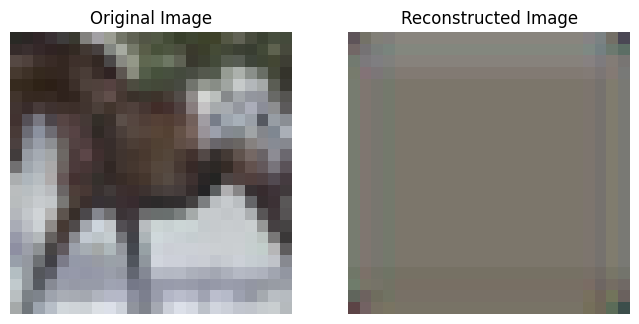

In [4]:
import matplotlib.pyplot as plt
import random

# Select a random sample from the validation dataset
sample_index = random.randint(0, len(validation_dataset) - 1)
sample_image, _ = validation_dataset[sample_index]

# Pass the sample through the autoencoder
reconstructed_image, _, _,_,_,_ = model(sample_image.unsqueeze(0))  # Unsqueezing to add batch dimension

# Convert PyTorch tensors to numpy arrays and remove batch dimension
sample_image = sample_image.permute(1, 2, 0).numpy()
reconstructed_image = reconstructed_image.squeeze(0).permute(1, 2, 0).detach().numpy()

# Plot the original image and its reconstruction
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image)
plt.axis('off')

plt.show()
